### Analysis of Yelp data result

In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline

In [2]:
!ls -alt *.pkl

-rw-rw-r--. 1 huaqingj huaqingj    60214 2月  10 05:06 MNARyelp_log35.pkl
-rw-rw-r--. 1 huaqingj huaqingj    60214 2月   9 19:54 MARyelp_log35.pkl
-rw-rw-r--. 1 huaqingj huaqingj 41600163 1月  20 10:19 Xsps.pkl
-rw-rw-r--. 1 huaqingj huaqingj  2080162 1月  17 11:02 Xmat.pkl
-rw-rw-r--. 1 huaqingj huaqingj    80160 1月  16 21:04 Ymat.pkl


In [3]:
with open("./MARyelp_log35.pkl", "rb") as f:
#with open("./results/MARyelp_log35.pkl", "rb") as f:
    MARres = pickle.load(f)
    
with open("./MNARyelp_log35.pkl", "rb") as f:
#with open("./results/MNARyelp_log35_Xsps30k.pkl", "rb") as f:
    MNARres = pickle.load(f)

In [4]:
def AUCplot(MARres, MNARres, i, is_plot=False):
    marres,  mnarres = MARres[i], MNARres[i]
    marprobs, margts = marres[0].cpu().numpy(), marres[1].cpu().numpy()
    mnarprobs, mnargts = mnarres[0].cpu().numpy(), mnarres[1].cpu().numpy()
    marfpr, martpr, marthre = metrics.roc_curve(margts, marprobs)
    mnarfpr, mnartpr, mnarthre = metrics.roc_curve(mnargts, mnarprobs)
    marauc = metrics.roc_auc_score(margts, marprobs)
    mnarauc = metrics.roc_auc_score(mnargts, mnarprobs)
    if is_plot:
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(marfpr, martpr, "--r", label="MAR")
        plt.plot(mnarfpr, mnartpr, label="MNAR")
        plt.legend()
    return marauc, mnarauc
    

In [7]:
allaucs = [AUCplot(MARres, MNARres, i)  for i in range(1, 21)] 

In [8]:
allaucs = np.array(allaucs)
allaucdf = pd.DataFrame(allaucs)
allaucdf.columns = ["MAR", "MNAR"]
allaucdf

,MAR,MNAR
0,0.662335,0.663653
1,0.743800,0.734000
2,0.646462,0.619657
3,0.688421,0.673139
4,0.749119,0.789758
5,0.663524,0.661728
6,0.715552,0.709496
7,0.691304,0.672925
8,0.600161,0.591128
9,0.656839,0.637082


In [9]:
MARprobs = []
MARgt = []
MNARprobs = []
MNARgt = []
for i in range(1, len(MNARres)+1):
    mnarres = MNARres[i]
    MNARprobs.append(mnarres[0].cpu().numpy())
    MNARgt.append(mnarres[1].cpu().numpy())
for i in range(1, len(MARres)+1):
    marres = MARres[i]
    MARprobs.append(marres[0].cpu().numpy())
    MARgt.append(marres[1].cpu().numpy())

In [10]:
MARgt = np.concatenate(MARgt)
MNARgt = np.concatenate(MNARgt)
MARprobs = np.concatenate(MARprobs)
MNARprobs = np.concatenate(MNARprobs)

In [11]:
Data = {
    "Probs": np.concatenate([MNARprobs, MARprobs]),
    "Method": ["MNAR"] * len(MNARprobs) + ["MAR"] * len(MARprobs),
    "GT": np.concatenate([MNARgt, MARgt])
}
dfdata = pd.DataFrame(Data)

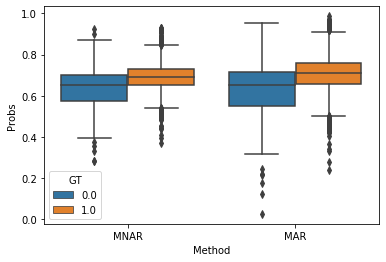

In [12]:
sns.boxplot(data=dfdata, x="Method", y="Probs", hue="GT")

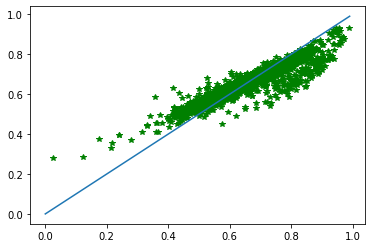

In [13]:
#plt.plot(MARgt[:200], "bo")
#plt.plot(MARgt[:200], MARprobs[:200], "rh")
#plt.plot(MARgt[:200], MNARprobs[:200], "g*")
plt.plot(MARprobs[:], MNARprobs[:], "g*")
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))

In [14]:
dfdatagrp = dfdata.groupby(["Method", "GT"])

In [15]:
dfdatagrp.describe()

Probs                                                    \
             count      mean       std       min       25%       50%   
Method GT                                                              
MAR    0.0   956.0  0.631640  0.111700  0.025142  0.551478  0.652062   
       1.0  2031.0  0.704073  0.095779  0.240222  0.655627  0.710458   
MNAR   0.0   956.0  0.638135  0.081507  0.280464  0.576282  0.653791   
       1.0  2031.0  0.687637  0.070121  0.367822  0.654367  0.692650   

                                
                 75%       max  
Method GT                       
MAR    0.0  0.714221  0.953735  
       1.0  0.759943  0.986519  
MNAR   0.0  0.699829  0.924470  
       1.0  0.730696  0.930613

In [16]:
from sklearn import metrics

In [17]:
metrics.roc_auc_score(MARgt, MARprobs)

0.6867456104027738

In [18]:
metrics.roc_auc_score(MNARgt, MNARprobs)

0.67279809397848

In [19]:
marfpr, martpr, marthre = metrics.roc_curve(MARgt, MARprobs)
mnarfpr, mnartpr, mnarthre = metrics.roc_curve(MNARgt, MNARprobs)

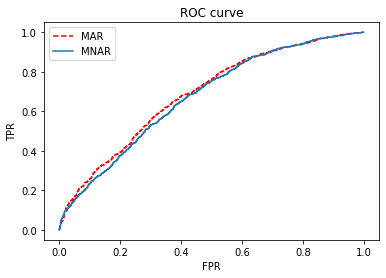

In [20]:
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(marfpr, martpr, "--r", label="MAR")
plt.plot(mnarfpr, mnartpr, label="MNAR")
plt.legend()

In [21]:
with open("Ymat.pkl", "rb") as f:
    Y = pickle.load(f)

In [23]:
Yno = Y[Y!=-1]

(array([  52.,    0.,  220.,    0.,    0.,  684.,    0., 1227.,    0.,
         804.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

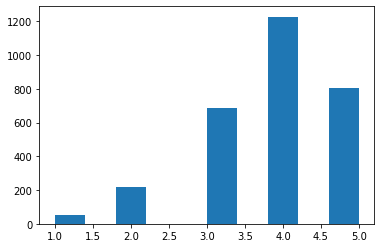

In [26]:
plt.hist(Yno)